In [1]:
!pip install ultralytics opencv-python-headless Pillow ipywidgets -q

print("✅ All libraries installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.2 MB/s eta 0:00:00
✅ All libraries installed successfully!


In [2]:
import torch
import cv2
import numpy as np
from ultralytics import YOLO
from IPython.display import display, Javascript, clear_output
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from PIL import Image
import io
import time
import ipywidgets as widgets

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🖥️  Device: {device.upper()}")
if device == 'cuda':
    print(f"⚡ GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️  No GPU found. Detection will run on CPU (slower). Recommended: Enable T4 GPU.")

print("\n✅ All libraries imported successfully!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🖥️  Device: CPU
⚠️  No GPU found. Detection will run on CPU (slower). Recommended: Enable T4 GPU.

✅ All libraries imported successfully!


In [3]:
# ✏️ Change model here: yolov8n / yolov8s / yolov8m / yolov8l
MODEL_NAME = 'yolov8n.pt'  # Nano = fastest for real-time

print(f"⏳ Loading {MODEL_NAME}...")
model = YOLO(MODEL_NAME)
model.to(device)

# Get class names
class_names = model.names
print(f"✅ Model loaded! Detects {len(class_names)} object classes.")
print(f"📋 Classes include: {', '.join(list(class_names.values())[:15])}... and more")

⏳ Loading yolov8n.pt...
✅ Model loaded! Detects 80 object classes.
📋 Classes include: person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird... and more


In [4]:
# ─── Color Palette (one color per class) ───────────────────────────────────
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(class_names), 3), dtype=np.uint8)

def draw_detections(frame, results, conf_threshold=0.4):
    """Draw bounding boxes, labels and confidence scores on frame."""
    for result in results:
        boxes = result.boxes
        if boxes is None:
            continue

        for box in boxes:
            conf = float(box.conf[0])
            if conf < conf_threshold:
                continue

            cls_id = int(box.cls[0])
            label = class_names[cls_id]
            color = [int(c) for c in COLORS[cls_id]]

            # Bounding box coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Draw rectangle
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

            # Label background
            text = f"{label}: {conf:.2f}"
            (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(frame, (x1, y1 - th - 10), (x1 + tw + 6, y1), color, -1)

            # Label text
            cv2.putText(frame, text, (x1 + 3, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    return frame


def frame_to_base64(frame):
    """Convert OpenCV frame to base64 string for display."""
    _, buffer = cv2.imencode('.jpg', frame, [cv2.IMWRITE_JPEG_QUALITY, 85])
    return b64encode(buffer).decode('utf-8')


def base64_to_frame(b64_string):
    """Convert base64 string from JS to OpenCV frame."""
    if ',' in b64_string:
        b64_string = b64_string.split(',')[1]
    img_bytes = b64decode(b64_string)
    img_array = np.frombuffer(img_bytes, dtype=np.uint8)
    frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return frame


print("✅ Helper functions defined!")

✅ Helper functions defined!


In [5]:
# JavaScript to capture webcam frame
CAPTURE_JS = """
async function captureFrame() {
    const video = document.createElement('video');
    const canvas = document.createElement('canvas');

    try {
        const stream = await navigator.mediaDevices.getUserMedia({
            video: { width: 640, height: 480, facingMode: 'user' }
        });

        video.srcObject = stream;
        await video.play();

        await new Promise(resolve => setTimeout(resolve, 500));

        canvas.width  = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);

        stream.getTracks().forEach(t => t.stop());

        return canvas.toDataURL('image/jpeg', 0.9);
    } catch(e) {
        return 'ERROR: ' + e.message;
    }
}
captureFrame();
"""

def capture_webcam_frame():
    """Capture one frame from webcam via JavaScript."""
    result = eval_js(CAPTURE_JS)
    if result.startswith('ERROR'):
        raise RuntimeError(f"Webcam error: {result}")
    return base64_to_frame(result)

print("✅ Webcam bridge ready!")
print("📷 When you run detection, your browser will ask for camera permission — click Allow!")

✅ Webcam bridge ready!
📷 When you run detection, your browser will ask for camera permission — click Allow!


In [6]:
from IPython.display import Image as IPImage
import warnings
warnings.filterwarnings('ignore')

print("📷 Capturing test frame from webcam...")
print("🔔 Allow camera access in your browser when prompted!")

try:
    frame = capture_webcam_frame()
    print(f"✅ Frame captured: {frame.shape[1]}x{frame.shape[0]} pixels")

    t0 = time.time()
    results = model(frame, verbose=False)
    inference_time = (time.time() - t0) * 1000

    annotated = draw_detections(frame.copy(), results, conf_threshold=0.4)

    n_detected = sum(len(r.boxes) for r in results)
    cv2.putText(annotated, f"Objects: {n_detected}  |  Inference: {inference_time:.1f}ms",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    _, buf = cv2.imencode('.jpg', cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    display(IPImage(data=buf.tobytes()))

    print(f"\n🎯 Detected {n_detected} object(s) in {inference_time:.1f}ms")
    for result in results:
        for box in result.boxes:
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            if conf >= 0.4:
                print(f"   → {class_names[cls_id]}: {conf:.2%} confidence")

except Exception as e:
    print(f"❌ Error: {e}")
    print("💡 Make sure to allow camera permissions in your browser!")

📷 Capturing test frame from webcam...
🔔 Allow camera access in your browser when prompted!
❌ Error: Webcam error: ERROR: Permission denied
💡 Make sure to allow camera permissions in your browser!


🚀 Starting Real-Time YOLO Detection!
   Confidence threshold : 0.45
   Max frames           : 100
   Press ■ (Stop) to end early

🔔 Allow camera access when your browser asks!
──────────────────────────────────────────────────


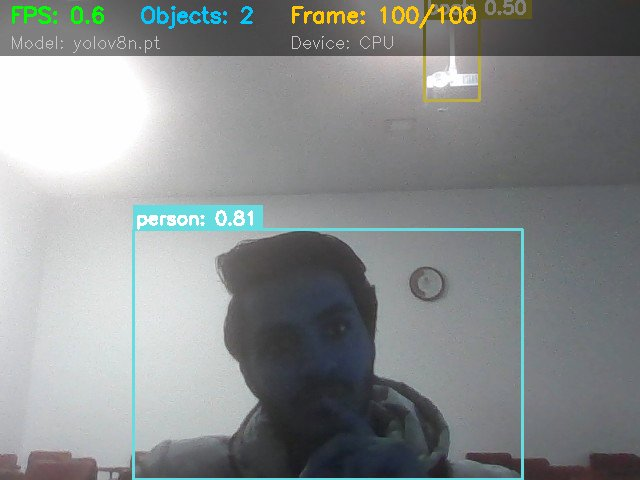

Frame   10 | FPS:   0.4 | Objects: 1
Frame   20 | FPS:   0.5 | Objects: 3
Frame   30 | FPS:   0.5 | Objects: 1
Frame   40 | FPS:   0.5 | Objects: 3
Frame   50 | FPS:   0.6 | Objects: 1
Frame   60 | FPS:   0.6 | Objects: 1
Frame   70 | FPS:   0.6 | Objects: 3
Frame   80 | FPS:   0.6 | Objects: 2
Frame   90 | FPS:   0.6 | Objects: 3
Frame  100 | FPS:   0.6 | Objects: 2

──────────────────────────────────────────────────
✅ Detection complete!
   Frames processed : 100
   Avg FPS          : 0.54
   Min FPS          : 0.10
   Max FPS          : 0.64


In [7]:
# ─── Configuration ─────────────────────────────────────────────────────────
CONF_THRESHOLD = 0.45   # Minimum confidence (0.0 – 1.0)
MAX_FRAMES     = 100    # Total frames to process
DISPLAY_EVERY  = 1      # Show every Nth frame
# ───────────────────────────────────────────────────────────────────────────

print("🚀 Starting Real-Time YOLO Detection!")
print(f"   Confidence threshold : {CONF_THRESHOLD}")
print(f"   Max frames           : {MAX_FRAMES}")
print("   Press ■ (Stop) to end early\n")
print("🔔 Allow camera access when your browser asks!")
print("─" * 50)

fps_history = []
frame_count = 0

display_img = display(IPImage(data=b''), display_id=True)

try:
    while frame_count < MAX_FRAMES:
        t_start = time.time()

        # 1. Capture frame
        frame = capture_webcam_frame()

        # 2. Run YOLO inference
        results = model(frame, verbose=False)

        # 3. Draw detections
        annotated = draw_detections(frame.copy(), results, CONF_THRESHOLD)

        # 4. Compute FPS
        elapsed = time.time() - t_start
        fps = 1.0 / elapsed if elapsed > 0 else 0
        fps_history.append(fps)
        avg_fps = np.mean(fps_history[-10:])

        # 5. Overlay Stats
        n_det = sum(len(r.boxes) for r in results)
        h, w = annotated.shape[:2]

        overlay = annotated.copy()
        cv2.rectangle(overlay, (0, 0), (w, 55), (0, 0, 0), -1)
        cv2.addWeighted(overlay, 0.5, annotated, 0.5, 0, annotated)

        cv2.putText(annotated, f"FPS: {avg_fps:.1f}",
                    (10, 22), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(annotated, f"Objects: {n_det}",
                    (140, 22), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 200, 255), 2)
        cv2.putText(annotated, f"Frame: {frame_count+1}/{MAX_FRAMES}",
                    (290, 22), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 200, 0), 2)
        cv2.putText(annotated, f"Model: {MODEL_NAME}",
                    (10, 48), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (200, 200, 200), 1)
        cv2.putText(annotated, f"Device: {device.upper()}",
                    (290, 48), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (200, 200, 200), 1)

        # 6. Display
        if frame_count % DISPLAY_EVERY == 0:
            rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
            _, buf = cv2.imencode('.jpg', rgb, [cv2.IMWRITE_JPEG_QUALITY, 85])
            display_img.update(IPImage(data=buf.tobytes()))

        frame_count += 1

        if frame_count % 10 == 0:
            print(f"Frame {frame_count:4d} | FPS: {avg_fps:5.1f} | Objects: {n_det}")

except KeyboardInterrupt:
    print("\n⏹️  Detection stopped by user.")
except Exception as e:
    print(f"\n❌ Error: {e}")

print("\n" + "─" * 50)
print(f"✅ Detection complete!")
print(f"   Frames processed : {frame_count}")
if fps_history:
    print(f"   Avg FPS          : {np.mean(fps_history):.2f}")
    print(f"   Min FPS          : {np.min(fps_history):.2f}")
    print(f"   Max FPS          : {np.max(fps_history):.2f}")

In [8]:
import os
from google.colab import drive

drive.mount('/content/drive')

SAVE_DIR = '/content/drive/MyDrive/YOLO_Detections'
os.makedirs(SAVE_DIR, exist_ok=True)

N_SAVE = 5  # Number of frames to capture and save

print(f"📸 Capturing and saving {N_SAVE} annotated frames to Google Drive...")

for i in range(N_SAVE):
    frame = capture_webcam_frame()
    results = model(frame, verbose=False)
    annotated = draw_detections(frame.copy(), results, conf_threshold=0.4)

    filename = f"{SAVE_DIR}/detection_{i+1:03d}.jpg"
    cv2.imwrite(filename, annotated)
    print(f"   Saved: {filename}")
    time.sleep(0.5)

print(f"\n✅ All {N_SAVE} frames saved to {SAVE_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📸 Capturing and saving 5 annotated frames to Google Drive...
   Saved: /content/drive/MyDrive/YOLO_Detections/detection_001.jpg
   Saved: /content/drive/MyDrive/YOLO_Detections/detection_002.jpg
   Saved: /content/drive/MyDrive/YOLO_Detections/detection_003.jpg
   Saved: /content/drive/MyDrive/YOLO_Detections/detection_004.jpg
   Saved: /content/drive/MyDrive/YOLO_Detections/detection_005.jpg

✅ All 5 frames saved to /content/drive/MyDrive/YOLO_Detections


In [9]:
import ipywidgets as widgets
from IPython.display import display as ipy_display, Image as IPImage

conf_slider = widgets.FloatSlider(
    value=0.45, min=0.1, max=0.95, step=0.05,
    description='Confidence:', style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

model_dropdown = widgets.Dropdown(
    options=['yolov8n.pt', 'yolov8s.pt', 'yolov8m.pt'],
    value=MODEL_NAME,
    description='Model:',
    style={'description_width': 'initial'}
)

run_button = widgets.Button(
    description='📸 Detect Once',
    button_style='success',
    layout=widgets.Layout(width='150px')
)

out = widgets.Output()

def on_run_click(b):
    with out:
        clear_output(wait=True)
        try:
            frame = capture_webcam_frame()
            results = model(frame, verbose=False)
            annotated = draw_detections(frame.copy(), results, conf_slider.value)

            n_det = sum(len(r.boxes) for r in results)
            cv2.putText(annotated, f"Objects: {n_det} | Conf >= {conf_slider.value:.2f}",
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

            rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
            _, buf = cv2.imencode('.jpg', rgb)
            ipy_display(IPImage(data=buf.tobytes()))
            print(f"\n🎯 {n_det} object(s) detected.")
        except Exception as e:
            print(f"Error: {e}")

run_button.on_click(on_run_click)

ipy_display(
    widgets.VBox([
        widgets.HTML('<h3>🎛️ Interactive YOLO Controls</h3>'),
        conf_slider,
        model_dropdown,
        run_button,
        out
    ])
)